In [1]:
import os
import sys
import inspect
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

In [2]:
from torch.utils.data.dataset import Dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [5]:
data_root = '/home/ubuntu/dev/LaneNet-Pytorch'
training_file = 'data/tusimple/train/train.txt'

In [6]:
from LaneNet.datasets import tuSimpleDataset

In [11]:
dataset = tuSimpleDataset(
    dataset_path=training_file,
    root='..',
    mode='hoge',
)
print(len(dataset))

2901


In [12]:
data = dataset[0]  # first data
image = data['image']
binary = data['binary']
instance = data['instance']
print(image.shape, image.dtype)
print(binary.shape, binary.dtype)
print(instance.shape, instance.dtype)

(720, 1280, 3) uint8
(720, 1280) uint8
(720, 1280) uint8


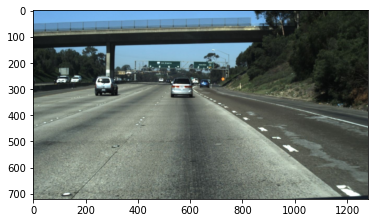

In [13]:
plt.imshow(image)

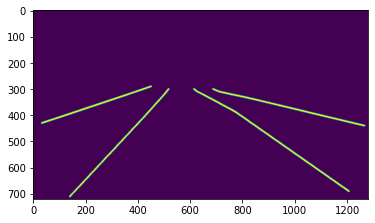

In [14]:
# Binary segmentation
plt.imshow(binary)

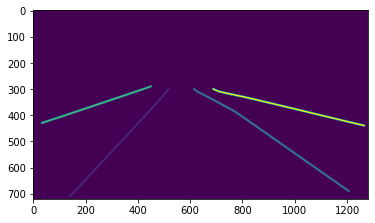

In [15]:
# Instance segmentation
plt.imshow(instance)

In [16]:
np.unique(binary)

array([  0, 255], dtype=uint8)

In [14]:
data[2]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [15]:
import torchvision.transforms.functional as VF

In [16]:
binary = VF.to_pil_image(data[1])

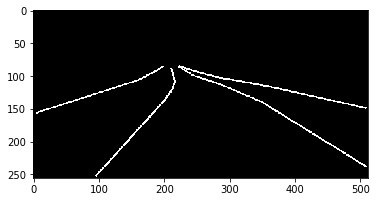

In [17]:
plt.imshow(binary)

In [18]:
instance = VF.to_pil_image(data[2])

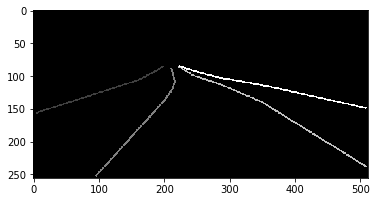

In [19]:
plt.imshow(instance)

In [20]:
src = VF.to_pil_image(dataset.rgb_normalize(data[0]))

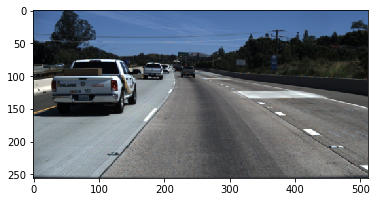

In [21]:
plt.imshow(src)